In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os 
DROPBOX_DIR = r'C:\Users\ande7\Dropbox\Apps\Overleaf\Thesis - Nash Bargaining\Figures'
plots_dir = os.path.join(os.getcwd(), 'Plots')
os.makedirs(plots_dir, exist_ok=True)

In [7]:
# Import montecarlo simulation results

# Load Data for simulation 

num_scenarios = 50000
time_horizon = 5 #  5,10,20
contract_type = 'Baseload'  # Baseload ,PAP

# Load scenarios from CSV files
scenario_pattern = f"{{type}}_scenarios_{time_horizon}y_{num_scenarios}s.csv"

# Load price scenarios
prices_df = pd.read_csv(f"scenarios/{scenario_pattern.format(type='price')}", index_col=0) # Mio EUR/GWh
prices_df.index = pd.to_datetime(prices_df.index)   

prices_mwh = prices_df * 1000  # Convert from EUR/GWh to EUR/MWh

#prices_mwh = prices_mwh + 0.01*prices_mwh.mean().mean()

# Load production scenarios
prod_df = pd.read_csv(f"scenarios/{scenario_pattern.format(type='production')}", index_col=0) # GWh
prod_df.index = pd.to_datetime(prod_df.index)

# Load capture rate scenarios
CR_df = pd.read_csv(f"scenarios/{scenario_pattern.format(type='capture_rate')}", index_col=0)
CR_df.index = pd.to_datetime(CR_df.index)    # Load load scenarios
load_df = pd.read_csv(f"scenarios/{scenario_pattern.format(type='load')}", index_col=0) # GWh
load_df.index = pd.to_datetime(load_df.index)

LR_df = pd.read_csv(f"scenarios/{scenario_pattern.format(type='load_capture_rate')}", index_col=0) # %
LR_df.index = pd.to_datetime(LR_df.index)

#Net earnings no contract 
net_earnings_no_contract_G = (prices_df * prod_df * CR_df) # Mio EUR
net_earnings_no_contract_L = (-prices_df * load_df * LR_df) # Mio  EUR 

#Capture Prices 
capture_price_G =  prices_mwh * CR_df
capture_price_L = prices_mwh * LR_df

In [8]:

k_clusters = 5000  #

# Sample all variables (keep this for extracting representative scenarios later)
prices_sample = prices_df.values.T[:num_scenarios]      # Shape: (scenarios, T)
prod_sample = prod_df.values.T[:num_scenarios]          # Shape: (scenarios, T)
CR_sample = CR_df.values.T[:num_scenarios]              # Shape: (scenarios, T)
consumption_sample = load_df.values.T[:num_scenarios]   # Shape: (scenarios, T)
LR_sample = LR_df.values.T[:num_scenarios]              # Shape: (scenarios, T)

# CORRECTED: Calculate annual revenues as per methodology
pi_G_annual = np.sum(prices_sample * prod_sample * CR_sample, axis=1)      # Shape: (scenarios,)
pi_L_annual = np.sum(-prices_sample * consumption_sample * LR_sample, axis=1)  # Shape: (scenarios,)

# Create 2D feature space as described in methodology
feature_space = np.column_stack([pi_G_annual, pi_L_annual])  # Shape: (scenarios, 2)

# Standardize the 2D revenue data
scaler = StandardScaler()
feature_space_scaled = scaler.fit_transform(feature_space)

print(f"2D Revenue Space Clustering: {num_scenarios} scenarios into {k_clusters} clusters")
print(f"Feature space shape: {feature_space.shape}")
print(f"Features: Generator Revenue (π^G) and Load Cost (π^L)")

# CORRECTED: Print scale information for revenues, not raw variables
print(f"\nRevenue scale analysis before standardization:")
print(f"Generator Revenue (π^G) - Mean: {np.mean(pi_G_annual):.2f}, Std: {np.std(pi_G_annual):.2f}")
print(f"                        Range: [{np.min(pi_G_annual):.2f}, {np.max(pi_G_annual):.2f}]")
print(f"Load Cost (π^L) - Mean: {np.mean(pi_L_annual):.2f}, Std: {np.std(pi_L_annual):.2f}")
print(f"                  Range: [{np.min(pi_L_annual):.2f}, {np.max(pi_L_annual):.2f}]")

# Apply K-means clustering on standardized 2D revenue space
kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10, init='k-means++')
labels = kmeans.fit_predict(feature_space_scaled)
centroids = kmeans.cluster_centers_

# Calculate probabilities for each cluster
unique_labels, counts = np.unique(labels, return_counts=True)
probabilities = counts / len(labels)

print(f"\nCluster Statistics:")
print(f"Number of non-empty clusters: {len(unique_labels)}")
print(f"Cluster size range: [{np.min(counts)}, {np.max(counts)}] scenarios")
print(f"Probability range: [{np.min(probabilities):.6f}, {np.max(probabilities):.6f}]")
print(f"Total probability sum: {np.sum(probabilities):.6f}")

# Find representative scenarios (closest actual scenarios to each centroid)
representative_scenarios = []
representative_probabilities = []

for cluster_id in range(k_clusters):
    # Get all scenarios in this cluster
    cluster_mask = labels == cluster_id
    cluster_indices = np.where(cluster_mask)[0]
    
    # Skip empty clusters
    if len(cluster_indices) == 0:
        print(f"Warning: Cluster {cluster_id} is empty")
        continue
        
    cluster_data_scaled = feature_space_scaled[cluster_mask]
    centroid = centroids[cluster_id]
    
    # Find closest actual scenario to centroid in scaled revenue space
    distances = np.linalg.norm(cluster_data_scaled - centroid, axis=1)
    closest_local_idx = np.argmin(distances)
    closest_global_idx = cluster_indices[closest_local_idx]
    
    representative_scenarios.append(closest_global_idx)
    representative_probabilities.append(len(cluster_indices) / num_scenarios)

representative_scenarios = np.array(representative_scenarios)
representative_probabilities = np.array(representative_probabilities)

# Extract representative data for all variables using the selected scenarios
repr_prices = prices_sample[representative_scenarios]
repr_prod = prod_sample[representative_scenarios]
repr_CR = CR_sample[representative_scenarios]
repr_consumption = consumption_sample[representative_scenarios]
repr_LR = LR_sample[representative_scenarios]

# Calculate net earnings for representative scenarios (time-series preserved)
repr_net_earnings_G = repr_prices * repr_prod * repr_CR
repr_net_earnings_L = -repr_prices * repr_consumption * repr_LR

# Verify revenue consistency with original clustering space
repr_pi_G_annual = np.sum(repr_net_earnings_G, axis=1)
repr_pi_L_annual = np.sum(repr_net_earnings_L, axis=1)

print(f"\nRepresentative Scenarios Extracted:")
print(f"Number of representative scenarios: {len(representative_scenarios)}")
print(f"Representative probabilities sum: {np.sum(representative_probabilities):.6f}")
print(f"Generator revenue range: [{np.min(repr_pi_G_annual):.2f}, {np.max(repr_pi_G_annual):.2f}]")
print(f"Load cost range: [{np.min(repr_pi_L_annual):.2f}, {np.max(repr_pi_L_annual):.2f}]")

# VERIFICATION: Check that revenue space is preserved
print(f"\nRevenue Space Verification:")
print(f"Original revenue space coverage:")
print(f"  Generator: [{np.min(pi_G_annual):.2f}, {np.max(pi_G_annual):.2f}]")
print(f"  Load: [{np.min(pi_L_annual):.2f}, {np.max(pi_L_annual):.2f}]")
print(f"Representative revenue space coverage:")
print(f"  Generator: [{np.min(repr_pi_G_annual):.2f}, {np.max(repr_pi_G_annual):.2f}]")
print(f"  Load: [{np.min(repr_pi_L_annual):.2f}, {np.max(repr_pi_L_annual):.2f}]")


2D Revenue Space Clustering: 50000 scenarios into 5000 clusters
Feature space shape: (50000, 2)
Features: Generator Revenue (π^G) and Load Cost (π^L)

Revenue scale analysis before standardization:
Generator Revenue (π^G) - Mean: 25.25, Std: 5.78
                        Range: [7.88, 53.83]
Load Cost (π^L) - Mean: -67.22, Std: 14.51
                  Range: [-132.82, -21.58]

Cluster Statistics:
Number of non-empty clusters: 5000
Cluster size range: [1, 35] scenarios
Probability range: [0.000020, 0.000700]
Total probability sum: 1.000000

Representative Scenarios Extracted:
Number of representative scenarios: 5000
Representative probabilities sum: 1.000000
Generator revenue range: [7.88, 53.83]
Load cost range: [-132.82, -21.58]

Revenue Space Verification:
Original revenue space coverage:
  Generator: [7.88, 53.83]
  Load: [-132.82, -21.58]
Representative revenue space coverage:
  Generator: [7.88, 53.83]
  Load: [-132.82, -21.58]


C:\Users\ande7\AppData\Local\Temp\ipykernel_9436\1049254643.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_to_plot, labels=labels_box, patch_artist=True)


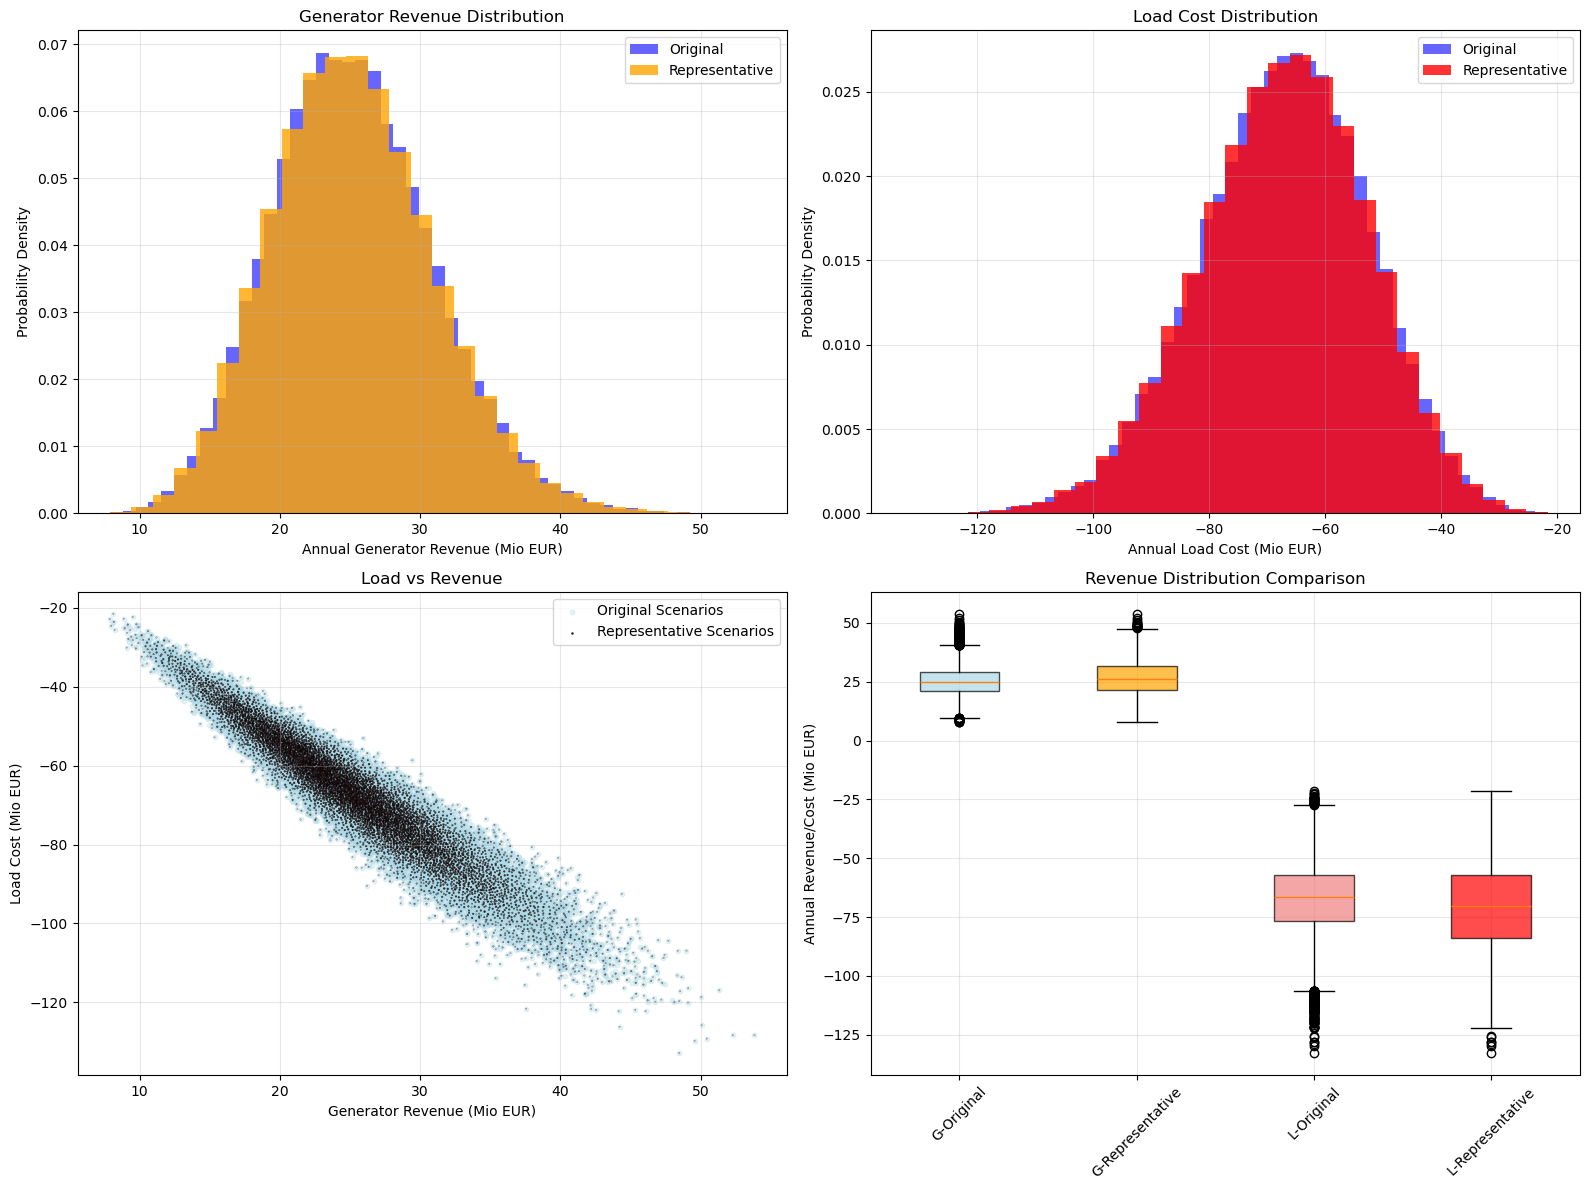

In [9]:
original_weights = np.ones(len(pi_G_annual))/len(pi_G_annual)
plt.figure(figsize=(16, 12))
# 1. Generator Annual Revenue comparison
plt.subplot(2, 2, 1)
plt.hist(pi_G_annual, weights=original_weights, bins=50, alpha=0.6, label='Original', color='blue', density=True)
plt.hist(repr_pi_G_annual,weights=representative_probabilities, bins=30, alpha=0.8, label='Representative', color='orange', density=True)
plt.xlabel('Annual Generator Revenue (Mio EUR)')
plt.ylabel('Probability Density')
plt.title('Generator Revenue Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Load Annual Cost comparison
plt.subplot(2, 2, 2)
plt.hist(pi_L_annual,weights = original_weights, bins=50, alpha=0.6, label='Original', color='blue', density=True)
plt.hist(repr_pi_L_annual,weights=representative_probabilities, bins=30, alpha=0.8, label='Representative', color='red', density=True)
plt.xlabel('Annual Load Cost (Mio EUR)')
plt.ylabel('Probability Density')
plt.title('Load Cost Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. 2D Revenue Space Scatter Plot
plt.subplot(2, 2, 3)
# Plot original scenarios as background
plt.scatter(pi_G_annual, pi_L_annual, alpha=0.3, s=10, color='lightblue', label='Original Scenarios')
# Plot representative scenarios
plt.scatter(repr_pi_G_annual, repr_pi_L_annual, 
           s=representative_probabilities*2000, # Size proportional to probability
           alpha=0.8, color='red', edgecolors='black', linewidth=1,
           label='Representative Scenarios')
plt.xlabel('Generator Revenue (Mio EUR)')
plt.ylabel('Load Cost (Mio EUR)')
plt.title('Load vs Revenue')
plt.legend()
plt.grid(True, alpha=0.3)


# 5. Box plot comparison (Annual Revenues)
plt.subplot(2, 2, 4)
data_to_plot = [pi_G_annual, repr_pi_G_annual, pi_L_annual, repr_pi_L_annual]
labels_box = ['G-Original', 'G-Representative', 'L-Original', 'L-Representative']
colors_box = ['lightblue', 'orange', 'lightcoral', 'red']

box_plot = plt.boxplot(data_to_plot, labels=labels_box, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.xticks(rotation=45)
plt.ylabel('Annual Revenue/Cost (Mio EUR)')
plt.title('Revenue Distribution Comparison')
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

In [10]:
(repr_pi_G_annual*representative_probabilities).shape

(5000,)

In [11]:
# Save joint clustering results: scenarios and probabilities

# Create time index matching original data
time_index = prices_df.index

# Create directory for reduced scenarios
reduced_dir = 'scenarios'
os.makedirs(reduced_dir, exist_ok=True)

# Define pattern for reduced scenario files
reduced_scenario_pattern = f"{{type}}_scenarios_reduced_{time_horizon}y_{k_clusters}s.csv"

print("Saving joint clustering results in original format...")

# 1. Save reduced price scenarios (consistent for both G and L)
reduced_prices_df = pd.DataFrame(
    repr_prices.T,  # Transpose to get (time, scenarios) format like original
    index=time_index,
    columns=[f'Scenario_{i+1}' for i in range(len(representative_scenarios))]
)
reduced_prices_df.to_csv(f"scenarios/{reduced_scenario_pattern.format(type='price')}")

# 2. Save reduced production scenarios (Generator)
reduced_prod_df = pd.DataFrame(
    repr_prod.T,  # Transpose to get (time, scenarios) format
    index=time_index,
    columns=[f'Scenario_{i+1}' for i in range(len(representative_scenarios))]
)
reduced_prod_df.to_csv(f"scenarios/{reduced_scenario_pattern.format(type='production')}")

# 3. Save reduced capture rate scenarios (Generator)
reduced_CR_df = pd.DataFrame(
    repr_CR.T,  # Transpose to get (time, scenarios) format
    index=time_index,
    columns=[f'Scenario_{i+1}' for i in range(len(representative_scenarios))]
)
reduced_CR_df.to_csv(f"scenarios/{reduced_scenario_pattern.format(type='capture_rate')}")

# 4. Save reduced load scenarios
reduced_load_df = pd.DataFrame(
    repr_consumption.T,  # Transpose to get (time, scenarios) format
    index=time_index,
    columns=[f'Scenario_{i+1}' for i in range(len(representative_scenarios))]
)
reduced_load_df.to_csv(f"scenarios/{reduced_scenario_pattern.format(type='load')}")

# 5. Save reduced load capture rate scenarios
reduced_LR_df = pd.DataFrame(
    repr_LR.T,  # Transpose to get (time, scenarios) format
    index=time_index,
    columns=[f'Scenario_{i+1}' for i in range(len(representative_scenarios))]
)
reduced_LR_df.to_csv(f"scenarios/{reduced_scenario_pattern.format(type='load_capture_rate')}")

# 6. Save scenario probabilities as CSV
probabilities_df =  pd.DataFrame({
    'Centroid_ID': [f'Centroid_{i+1}' for i in range(len(unique_labels))],
    'Probability': representative_probabilities
})

# Save probabilities
prob_filename = f"scenarios/scenario_probabilities_{time_horizon}y_{k_clusters}s.csv"
probabilities_df.to_csv(f"scenarios/{reduced_scenario_pattern.format(type='probabilities')}", index=False)

print(f"Joint clustering results saved:")
print(f"  - {reduced_scenario_pattern.format(type='price')}")
print(f"  - {reduced_scenario_pattern.format(type='production')}")
print(f"  - {reduced_scenario_pattern.format(type='capture_rate')}")
print(f"  - {reduced_scenario_pattern.format(type='load')}")
print(f"  - {reduced_scenario_pattern.format(type='load_capture_rate')}")
print(f"  -  {reduced_scenario_pattern.format(type='probabilities')}")

Saving joint clustering results in original format...
Joint clustering results saved:
  - price_scenarios_reduced_5y_5000s.csv
  - production_scenarios_reduced_5y_5000s.csv
  - capture_rate_scenarios_reduced_5y_5000s.csv
  - load_scenarios_reduced_5y_5000s.csv
  - load_capture_rate_scenarios_reduced_5y_5000s.csv
  -  probabilities_scenarios_reduced_5y_5000s.csv
